In [2]:
import warnings
warnings.filterwarnings('ignore',category=FutureWarning)
warnings.filterwarnings('ignore',category=DeprecationWarning)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_validate, KFold, RepeatedKFold, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler
from sklearn.linear_model import LinearRegression
import time
import cudf
from cuml.ensemble import RandomForestRegressor as cuRF
import math
import xgboost as xgb
from tqdm import tqdm

#### Output file

In [3]:
sourceFile = open("gpu_logs/ensemble_porto_336.txt", 'w')

### Load the data

In [4]:
df = pd.read_pickle("../datasets/df_location.pkl")
## Leaving the first house (public building out) due to its different profile
df = df.iloc[:, [0, 2, 1]].reset_index(drop=True)
number_of_houses = df.Location.nunique()
num_samples_per_house = df.Location.value_counts()[1]
df.reset_index(drop=True, inplace=True)
df

,Time,Location,Energy
0,2019-01-01 00:00:00,0,2.964000
1,2019-01-01 00:15:00,0,2.584000
2,2019-01-01 00:30:00,0,3.071000
3,2019-01-01 00:45:00,0,2.694000
4,2019-01-01 01:00:00,0,2.569000
...,...,...,...
1791931,2020-01-01 22:45:00,50,0.753222
1791932,2020-01-01 23:00:00,50,0.716855
1791933,2020-01-01 23:15:00,50,0.735802
1791934,2020-01-01 23:30:00,50,0.485237


In [5]:
#trunc = lambda x: math.trunc(10000 * x) / 10000
#df_trunc = pd.DataFrame(df['Energy']).applymap(trunc)
#df = pd.concat([df.iloc[:, 0:-1], df_trunc], axis=1)
#df

### Auxiliary functions

In [6]:
def plot_results(preds: np.array, actuals: np.array, title: str):
    
    plt.scatter(actuals, preds, c='b', label='predicted')
    plt.xlabel('actual')
    plt.ylabel('predicted')
    plt.title(title)
    plt.xlim(0, plt.xlim()[1])
    plt.ylim(0, plt.ylim()[1])
    _ = plt.plot([0, 100], [0, 100], '--r', label='y=x')
    plt.legend()
    plt.show()

def truncate_metric(metric):
    m = math.trunc(10000 * metric) / 10000
    return m 
    
def performance_metrics(preds: np.array, actuals: np.array, filename):

    # calculate performance metrics
    
    mse = truncate_metric(mean_squared_error(actuals, preds))
    wape = truncate_metric(np.sum(np.abs(preds - actuals)) / np.sum(np.abs(actuals))) * 100
    r2 = truncate_metric(r2_score(actuals, preds))
    
    # print performance metrics
    print('MSE: %.4f' % mse, file=filename)
    print('WAPE: %.2f' % wape, file=filename)
    print('R2: %.4f' % r2, file=filename)
    return mse, wape, r2

#@jit(target_backend='cuda')
def build_model(estimator, X_train: np.array, y_train: np.array, X_test: np.array):
    
    model = estimator
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    
    return model, preds

def validate(estimator, X_train, y_train):
    scores = cross_validate(estimator, X_train, y_train, scoring=['r2', 'neg_mean_squared_error'])
    return scores
    

In [7]:
def total_averaged_metrics(metrics_list, filename):
    
    print("Total Averaged MSE: {}".format(np.round(sum(i for i, j, k in metrics_list)/len(metrics_list),3)), file=filename)
    print("Total Averaged WAPE: {}".format(np.round(sum(j for i, j, k in metrics_list)/len(metrics_list),3)), file=filename)
    print("Total Averaged R2: {}".format(np.round(sum(k for i, j, k in metrics_list)/len(metrics_list),3)), file=filename)

def past_timesteps(df, number_of_timesteps):
    df = df.sort_values(by=['Location', 'Time'])
    for i in tqdm(range(1, (number_of_timesteps + 1))):
        df.loc[df['Time'].shift(i) == df['Time'] - pd.Timedelta(i * 15, 'm'), f"energy_lag_{i}"] = df['Energy'].shift(i)
    df.dropna(inplace=True)
    df.reset_index(drop=True, inplace=True)
    return df

#def past_timesteps(df, number_of_timesteps):
#    # Sort the dataframe by location and time
#    df = df.sort_values(by=['Location', 'Time'])
#
#    # Compute rolling window over time axis to extract past energy values for each location
#    energy_lags = [f"energy_lag_{i}" for i in range(1, number_of_timesteps+1)]
#    past_energy = df.groupby('Location')['Energy'].rolling(window=number_of_timesteps, min_periods=1).apply(np.mean())
#    # Add new columns to the dataframe for each past energy value
#    for i, energy_lag in enumerate(energy_lags):
#        df[energy_lag] = past_energy.apply(lambda x: x[-i-1] if isinstance(x, list) and len(x)>=i+1 else x)
#
#    # Drop rows with missing values
#    df.dropna(inplace=True)
#    df.reset_index(drop=True, inplace=True)
#
#    return df


def last_energy_points_full(df, number_timesteps, num_samples_per_house):
    X = pd.DataFrame()
    other_feats = df.iloc[:,:2]
    for i in range(1, (number_timesteps + 1) ):
        X[f'Energy_{i*15}'] = df['Energy'].shift(i)
    y = df.copy().iloc[:,2]
    y.iloc[:number_timesteps] = np.nan
    ## Remove samples in between each house
    for h in range(1, number_of_houses):
        for i in range(0, number_timesteps):
            X.iloc[(num_samples_per_house+i)*h] = np.nan
            y.iloc[(num_samples_per_house+i)*h] = np.nan
    X = pd.concat([other_feats, X], axis=1)
    X.dropna(inplace=True)
    X.reset_index(drop=True, inplace=True)
    y.dropna(inplace=True)
    y.reset_index(drop=True, inplace=True)
    y.columns = ["Energy"]
    dataframe = pd.concat([X,y.rename('Energy')], axis=1)
    assert number_of_houses == (df.shape[0] - dataframe.shape[0]) / number_timesteps, "Something went wrong with preprocessing"
    return dataframe
    

In [8]:
def normalize_training(X_train):
    scaler = MinMaxScaler(feature_range=(0,1))
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    return X_train, scaler

### Cross Validate

In [ ]:
#scores = validate(xgb.XGBRegressor(seed=0), X_train, y_train)
#cv_mse = np.round(scores['test_neg_mean_squared_error'].mean() * (-1),4)
#cv_r2 = np.round(scores['test_r2'].mean(),5)
#print("CV MSE: {} ".format(cv_mse))
#print("CV R2: {} ".format(cv_r2))
#metrics_list.append((cv_mse,cv_rmse,cv_mae,mape,cv_r2))

## Leave 10 houses for test (demonstration)

In [ ]:
number_of_timesteps = 336

In [ ]:
df_new = past_timesteps(df, number_of_timesteps)
df_new

In [ ]:
df_new['DayOfWeek'] = df_new['Time'].dt.dayofweek
df_new['Weekend'] = df_new['Time'].dt.dayofweek.isin([5, 6]).astype(int)
df_new['Hour'] = df_new['Time'].dt.hour
df_new

In [ ]:
df_new.to_csv("data/porto_halfweek.csv", index=False)

In [10]:
def test_leave_house_out(df, estimator, locations, filename):
    #df_new = past_timesteps(df, number_timesteps)
    #df_new['DayOfWeek'] = df_new['Time'].dt.dayofweek
    #df_new['Weekend'] = df_new['Time'].dt.dayofweek.isin([5,6]).astype(int)
    #df_new['Hour'] = df_new['Time'].dt.hour
    test = df[df['Location'].isin(locations)]
    train = df[~df['Location'].isin(locations)]
    print("Train set: ", train.shape)
    print("Test set: ", test.shape)
    X_train = train.drop(['Time', 'Energy', 'Location'], axis=1)
    X_test = test.drop(['Time', 'Energy', 'Location'], axis=1)
    y_train = train['Energy']
    y_test = test['Energy']
    X_train_norm, scaler = normalize_training(X_train)
    X_test_norm = scaler.transform(X_test)

    model = estimator
    init = time.time()
    model.fit(X_train_norm, y_train)
    y_pred = model.predict(X_test_norm)
    end = time.time()
    print('Elapsed time: {:.4f} s'.format(end - init), file=filename)
    mse, wape, r2 = performance_metrics(y_pred, y_test.values.reshape(-1), filename)
    return mse, wape, r2, model

## Predict  10 folds with 10 random houses for test

In [9]:
df = pd.read_csv("data/porto_halfweek.csv")
df

,Time,Location,Energy,energy_lag_1,energy_lag_2,energy_lag_3,energy_lag_4,energy_lag_5,energy_lag_6,energy_lag_7,...,energy_lag_330,energy_lag_331,energy_lag_332,energy_lag_333,energy_lag_334,energy_lag_335,energy_lag_336,DayOfWeek,Weekend,Hour
0,2019-01-04 12:00:00,0,6.596000,6.192000,6.357000,4.281000,4.530000,4.279000,3.902000,4.061000,...,2.558000,3.174000,2.569000,2.694000,3.071000,2.584000,2.964000,4,0,12
1,2019-01-04 12:15:00,0,6.653000,6.596000,6.192000,6.357000,4.281000,4.530000,4.279000,3.902000,...,2.922000,2.558000,3.174000,2.569000,2.694000,3.071000,2.584000,4,0,12
2,2019-01-04 12:30:00,0,7.054000,6.653000,6.596000,6.192000,6.357000,4.281000,4.530000,4.279000,...,2.994000,2.922000,2.558000,3.174000,2.569000,2.694000,3.071000,4,0,12
3,2019-01-04 12:45:00,0,6.929000,7.054000,6.653000,6.596000,6.192000,6.357000,4.281000,4.530000,...,3.223000,2.994000,2.922000,2.558000,3.174000,2.569000,2.694000,4,0,12
4,2019-01-04 13:00:00,0,6.717000,6.929000,7.054000,6.653000,6.596000,6.192000,6.357000,4.281000,...,2.553000,3.223000,2.994000,2.922000,2.558000,3.174000,2.569000,4,0,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1774795,2020-01-01 22:45:00,50,0.753222,1.099100,0.453906,0.481770,0.483173,0.467528,1.001887,0.552398,...,0.422658,0.433184,0.410480,0.429675,0.424639,0.420181,0.458736,2,0,22
1774796,2020-01-01 23:00:00,50,0.716855,0.753222,1.099100,0.453906,0.481770,0.483173,0.467528,1.001887,...,0.374650,0.422658,0.433184,0.410480,0.429675,0.424639,0.420181,2,0,23
1774797,2020-01-01 23:15:00,50,0.735802,0.716855,0.753222,1.099100,0.453906,0.481770,0.483173,0.467528,...,0.358180,0.374650,0.422658,0.433184,0.410480,0.429675,0.424639,2,0,23
1774798,2020-01-01 23:30:00,50,0.485237,0.735802,0.716855,0.753222,1.099100,0.453906,0.481770,0.483173,...,0.437601,0.358180,0.374650,0.422658,0.433184,0.410480,0.429675,2,0,23


In [11]:
df.isna().sum().sum()

0

In [12]:
#num_houses_test = 10

In [13]:
kf = RepeatedKFold(n_splits=5, n_repeats=2, random_state=42) 
locations = []
for _, test_index in kf.split(df['Location'].unique()):
    locations.append(test_index)
locations

[array([ 3, 12, 13, 17, 24, 30, 31, 32, 40, 43, 46]),
 array([ 4,  6,  8, 15, 19, 33, 36, 47, 48, 49]),
 array([ 0,  9, 11, 16, 25, 26, 27, 34, 44, 45]),
 array([ 1,  2,  5, 21, 23, 29, 35, 37, 39, 41]),
 array([ 7, 10, 14, 18, 20, 22, 28, 38, 42, 50]),
 array([ 0,  2, 10, 18, 23, 30, 36, 41, 45, 47, 49]),
 array([ 4,  8, 12, 20, 21, 26, 29, 31, 32, 33]),
 array([ 9, 14, 15, 22, 24, 37, 40, 42, 44, 48]),
 array([ 3,  5, 11, 17, 25, 28, 35, 38, 39, 50]),
 array([ 1,  6,  7, 13, 16, 19, 27, 34, 43, 46])]

In [14]:
df.Location.value_counts()

0     34800
38    34800
28    34800
29    34800
30    34800
31    34800
32    34800
33    34800
34    34800
35    34800
36    34800
37    34800
39    34800
26    34800
40    34800
41    34800
42    34800
43    34800
44    34800
45    34800
46    34800
47    34800
48    34800
49    34800
27    34800
25    34800
1     34800
12    34800
2     34800
3     34800
4     34800
5     34800
6     34800
7     34800
8     34800
9     34800
10    34800
11    34800
13    34800
24    34800
14    34800
15    34800
16    34800
17    34800
18    34800
19    34800
20    34800
21    34800
22    34800
23    34800
50    34800
Name: Location, dtype: int64

### Linear Regression

In [15]:
metrics_list_lr = []
print("\n----------------------------", file=sourceFile)
print("\nLinear Regression\n", file=sourceFile)
print("----------------------------\n", file=sourceFile)
for i in range(1):
    print("\nIteration", i, file=sourceFile)
    mse, wape, r2, model_lr = test_leave_house_out(df, LinearRegression(), locations[i], sourceFile)
    metrics_list_lr.append((mse, wape, r2))

Train set:  (1392000, 342)
Test set:  (382800, 342)


### XGBoost

In [16]:
metrics_list_xgb = []
print("\n----------------------------", file=sourceFile)
print("\nXGBoost\n", file=sourceFile)
print("----------------------------\n", file=sourceFile)
for i in range(1):
    print("\nIteration", i, file=sourceFile)
    mse, wape, r2, model_xgb = test_leave_house_out(df, xgb.XGBRegressor(tree_method='gpu_hist', seed=0), locations[i], sourceFile)
    metrics_list_xgb.append((mse, wape, r2))

Train set:  (1392000, 342)
Test set:  (382800, 342)


### Random Forest

In [17]:
metrics_list_rf = []
print("\n----------------------------", file=sourceFile)
print("\nRandom Forest\n", file=sourceFile)
print("----------------------------\n", file=sourceFile)
for i in range(1):
    print("\nIteration", i, file=sourceFile)
    mse, wape, r2, model_rf = test_leave_house_out(df, cuRF(), locations[i], sourceFile)
    metrics_list_rf.append((mse, wape, r2))

Train set:  (1392000, 342)
Test set:  (382800, 342)


/home/francisco.monteiro@av.it.pt/miniconda3/envs/rapids-23.02/lib/python3.8/site-packages/cuml/internals/api_decorators.py:190: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


## Averaged Metrics

In [18]:
print("\n\n\n", file=sourceFile)

In [19]:
print("\nLinear Regression", file=sourceFile)
total_averaged_metrics(metrics_list_lr, sourceFile)

In [20]:
print("\nXGBoost", file=sourceFile)
total_averaged_metrics(metrics_list_xgb, sourceFile)

In [21]:
print("\nRandom Forest", file=sourceFile)
total_averaged_metrics(metrics_list_rf, sourceFile)

### Feature Importance

In [28]:
print('Linear Regression\n')
for i,v in enumerate(model_lr.coef_):
    print('Feature: %0d, Score: %.5f' % (i,v))
print('XGBoost\n')
for i,v in enumerate(model_xgb.feature_importances_):
    print('Feature: %0d, Score: %.5f' % (i,v))

Linear Regression

Feature: 0, Score: 37.30329
Feature: 1, Score: -4.79895
Feature: 2, Score: 5.55266
Feature: 3, Score: -1.38244
Feature: 4, Score: 3.32429
Feature: 5, Score: 1.39767
Feature: 6, Score: -0.16592
Feature: 7, Score: -0.38640
Feature: 8, Score: 1.25203
Feature: 9, Score: 0.53768
Feature: 10, Score: 0.34410
Feature: 11, Score: 0.37568
Feature: 12, Score: 0.36550
Feature: 13, Score: -0.45311
Feature: 14, Score: 0.64323
Feature: 15, Score: 0.36002
Feature: 16, Score: -0.35261
Feature: 17, Score: -0.16207
Feature: 18, Score: 0.41923
Feature: 19, Score: -0.32241
Feature: 20, Score: 0.44057
Feature: 21, Score: 0.18997
Feature: 22, Score: 0.14923
Feature: 23, Score: -0.27101
Feature: 24, Score: 0.49148
Feature: 25, Score: -0.53822
Feature: 26, Score: 0.24015
Feature: 27, Score: -0.30973
Feature: 28, Score: 0.29044
Feature: 29, Score: -0.09923
Feature: 30, Score: -0.14207
Feature: 31, Score: 0.17622
Feature: 32, Score: 0.24177
Feature: 33, Score: -0.28092
Feature: 34, Score: 0.34

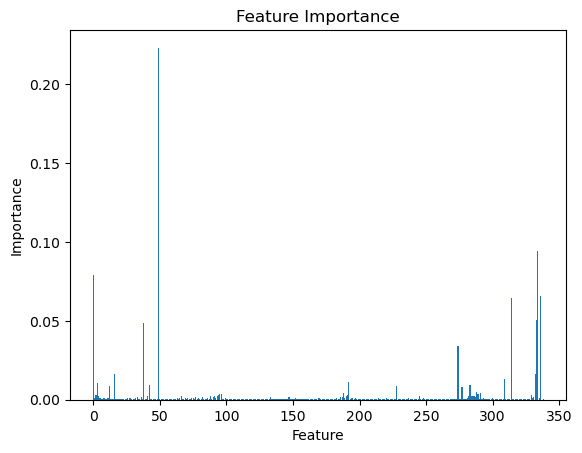

In [29]:
plt.bar(range(len(model_xgb.feature_importances_)),model_xgb.feature_importances_)
plt.title('Feature Importance')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.show()

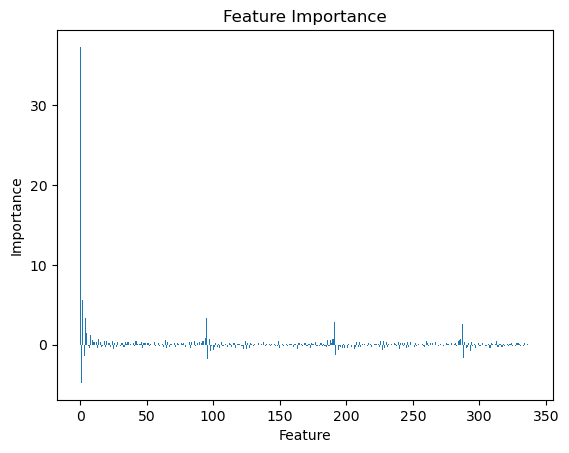

In [30]:
plt.bar(range(len(model_lr.coef_)),model_lr.coef_)
plt.title('Feature Importance')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.show()

In [34]:
columns

Index(['Time', 'Location', 'Energy', 'energy_lag_1', 'energy_lag_2',
       'energy_lag_3', 'energy_lag_4', 'energy_lag_5', 'energy_lag_6',
       'energy_lag_7',
       ...
       'energy_lag_330', 'energy_lag_331', 'energy_lag_332', 'energy_lag_333',
       'energy_lag_334', 'energy_lag_335', 'energy_lag_336', 'DayOfWeek',
       'Weekend', 'Hour'],
      dtype='object', length=342)

In [35]:
columns = df.drop(["Energy", "Location", "Time"], axis=1).columns
feature_importance = pd.Series(model_xgb.feature_importances_, index=columns)
feature_importance

energy_lag_1      0.079038
energy_lag_2      0.001047
energy_lag_3      0.002880
energy_lag_4      0.010746
energy_lag_5      0.002384
                    ...   
energy_lag_335    0.094388
energy_lag_336    0.000837
DayOfWeek         0.065668
Weekend           0.000000
Hour              0.000577
Length: 339, dtype: float32

In [36]:
features = feature_importance.nlargest(40).index
features

Index(['energy_lag_50', 'energy_lag_335', 'energy_lag_1', 'DayOfWeek',
       'energy_lag_315', 'energy_lag_334', 'energy_lag_39', 'energy_lag_275',
       'energy_lag_333', 'energy_lag_17', 'energy_lag_310', 'energy_lag_193',
       'energy_lag_4', 'energy_lag_284', 'energy_lag_43', 'energy_lag_229',
       'energy_lag_13', 'energy_lag_278', 'energy_lag_289', 'energy_lag_292',
       'energy_lag_189', 'energy_lag_290', 'energy_lag_97', 'energy_lag_96',
       'energy_lag_330', 'energy_lag_192', 'energy_lag_3', 'energy_lag_95',
       'energy_lag_191', 'energy_lag_67', 'energy_lag_283', 'energy_lag_42',
       'energy_lag_287', 'energy_lag_5', 'energy_lag_246', 'energy_lag_285',
       'energy_lag_94', 'energy_lag_286', 'energy_lag_89', 'energy_lag_92'],
      dtype='object')

In [ ]:
sourceFile.close()